# Image Optimization
Gradient based image optimization

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
from models import alexnet_wrapper
from utils import norm_image


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



### Set up tensorflow graph

In [3]:
# learning parameters
params = {
    'regularization_scale': 1e-4,
    'learning_rate': 0.05,
}

In [4]:
# specify which unit to use
UNIT_X = 4
UNIT_Y = 4
UNIT_CHAN = 42

In [5]:
# path to model checkpoint with pre-saved weights
CHECKPOINT_PATH = 'checkpoints/model.ckpt-115000'

In [6]:
# how many steps to run the optimization procedure for
NUM_STEPS = 64

#### Initialize image as random noise

In [7]:
# initialize images with random uniform noise in [0, 1]
image_initializer = tf.random_uniform_initializer(
    minval=0,
    maxval=1,
)

# regularize the image tensor directly with L2 regularization, penalizing very high values
image_regularizer = tf.contrib.layers.l2_regularizer(
    scale=params['regularization_scale']
)

# define the image tensor as a 128 x 128 x 3 image with the given initialization and regularizer
image_shape = (1, 128, 128, 3)
images = tf.get_variable(
    "images",
    image_shape,
    initializer=image_initializer,
    regularizer=image_regularizer)
    
print(images)

Instructions for updating:
Colocations handled automatically by placer.
<tf.Variable 'images:0' shape=(1, 128, 128, 3) dtype=float32_ref>


#### get tensor we want to optimize

In [8]:
# this function returns the output tensor for a given layer of the model. In this case,
# we can choose 'conv', 'conv1', 'conv2', ... 'conv4', corresponding to the first 5 conv layers
# of the model. To avoid needing static input sizes, we chop off the fully connected layers;
# they are not accessible

tensor_name = 'conv' # this is the 1st conv layer of alexnet
model_output = alexnet_wrapper(
    images,
    tensor_name=tensor_name,
    train=False
)

print(model_output)

Tensor("conv:0", shape=(1, 30, 30, 96), dtype=float32)


#### specify loss to minimize
In this example, I'm going to optimize for high activity for a single unit:
(x, y) = (4, 4)
channel = 16

(and add regularization)

In [9]:
# add all regularization terms in the tensorflow graph (there should be only the one we added for 'images')
total_regularization = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

# define the loss as the negative of the model output for a single unit with regularization added
loss = tf.negative(model_output[:, UNIT_X, UNIT_Y, UNIT_CHAN]) + total_regularization
print(loss)

Tensor("add:0", shape=(1,), dtype=float32)


#### now we need to minimize the loss

In [10]:
# construct a list of variables to train. In this case, it should only have 'images' in it
variables_to_train = [var for var in tf.trainable_variables() if "images:0" == var.name]

In [11]:
# define the optimizer and specify the operation to run on each train step (minimizing the optimizer)
optimizer = tf.train.AdamOptimizer(params['learning_rate'])
train_op = optimizer.minimize(loss, var_list=variables_to_train)

#### create a Session and restore model weights

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [13]:
# restore all variables except for the images and those related to the optimizer
all_variables = tf.get_collection_ref(tf.GraphKeys.GLOBAL_VARIABLES)
saver = tf.train.Saver(
    var_list=[v for v in all_variables if "images" not in v.name and "beta" not in v.name]
)
saver.restore(sess, CHECKPOINT_PATH)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt-115000


In [14]:
# for each step, compute the loss and the current image, then add them 
# to list for later inspection. Finally, take a step with the optimizer

loss_list = list()
image_list = list()

for step in range(NUM_STEPS):
    loss_list.append(sess.run(loss))
    image_list.append(norm_image(sess.run(images)))
    sess.run(train_op)

#### Plot outputs

Text(0.5, 0, 'Steps')

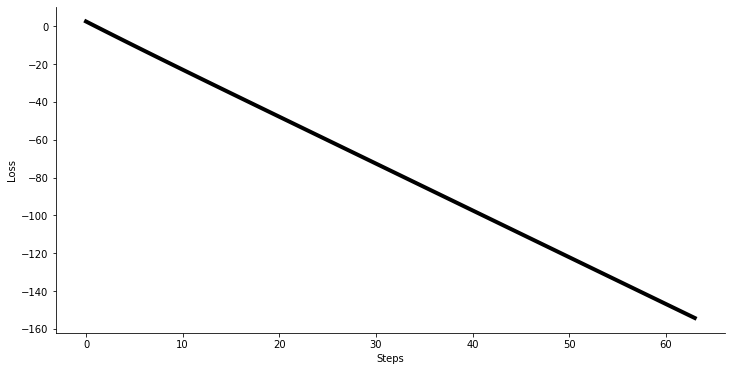

In [15]:
# plot the loss as a function of steps
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(loss_list, c='k', linewidth=4)

# plot formatting
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Loss')
ax.set_xlabel('Steps')


In [16]:
# stack all of the images so that the first dimensions indexes epochs
stacked_image_list = np.squeeze(np.stack(image_list))

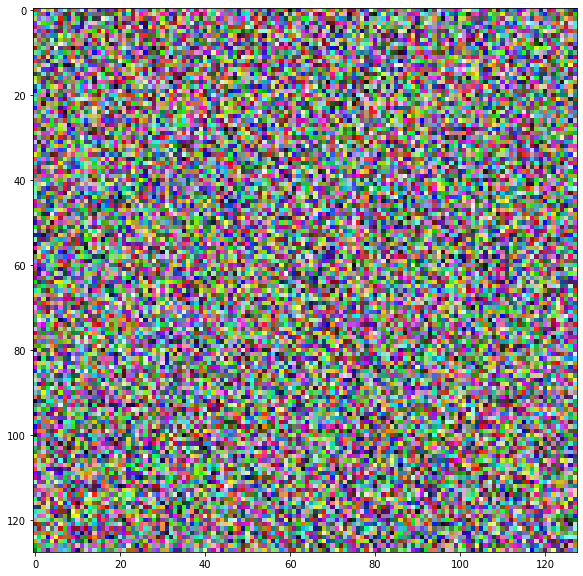

In [17]:
# create an animation of the image at each step
from matplotlib import animation
from IPython.display import HTML

plt.rcParams["animation.html"] = "jshtml"  # for matplotlib 2.1 and above, uses JavaScript

fig, ax = plt.subplots(figsize=(10, 10))
l = ax.imshow(np.zeros((128, 128, 3)))

def animate(i):
    l.set_data(stacked_image_list[i])

ani = animation.FuncAnimation(fig, animate, frames=NUM_STEPS)
ani

# Compare to true weights

In [18]:
weights_tensor = tf.get_default_graph().get_tensor_by_name("conv1/weights:0")

In [19]:
weights = sess.run(weights_tensor)

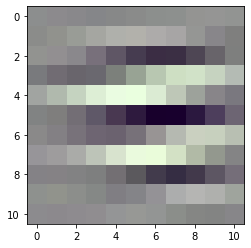

In [20]:
plt.imshow(norm_image(weights[:, :, :, UNIT_CHAN]))

# For fun, let's look at all the weights
We can choose one and see what the optimized output looks like

In [21]:
# move the last axis to the front so we can easily iterate over it
weights = np.moveaxis(weights, 3, 0)

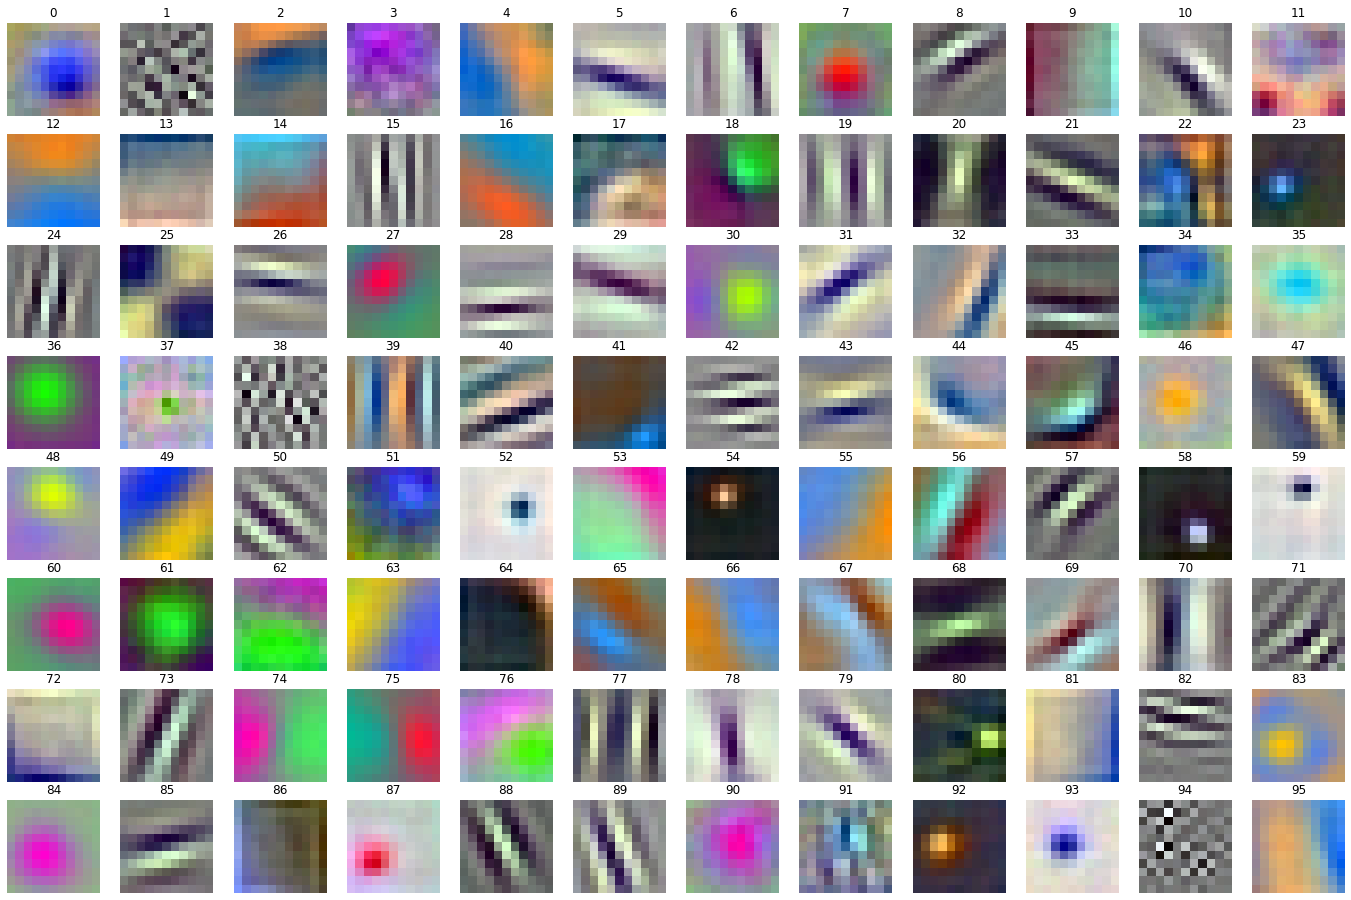

In [22]:
fig, axes = plt.subplots(figsize=(24, 16), nrows=8, ncols=12)
for kernel_idx, (kernel, ax) in enumerate(zip(weights, axes.ravel())):
    ax.imshow(norm_image(kernel))
    ax.axis('off')
    ax.set_title(kernel_idx)